In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import os
from sklearn.decomposition import PCA

from dredFISH.Design import PNMF
from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import * 

import importlib
importlib.reload(PNMF)


<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [6]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'res_dpnmf/v_python'
print(res_dir)
fig_dir = prj_dir + 'figures/'

# data (old)
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'
adata = anndata.read_h5ad(f, backed='r') # library size normed (no log)
# X = np.array(adata.X.todense()).copy() # already library size normalized
# adata

# data (CPM with rep)
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/inputs/smrt_withrep_X_subL5n100.npy'
cell_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/inputs/smrt_withrep_X_subL5n100_cells.csv'
clst_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/inputs/smrt_withrep_X_subL5n100_y_L5.npy'

/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python


In [7]:
# allen scrna matrix (CPM; only 10k genes)
X = np.load(scrna_genes_path, allow_pickle=True).T # cell by gene
cells = pd.read_csv(cell_path)['0'].values
# X.sum(axis=1)
y_l5 = np.load(clst_path, allow_pickle=True)

logX = np.log10(X+1)
X.shape, logX.shape, y_l5.shape, cells.shape

((38200, 10186), (38200, 10186), (38200,), (38200,))

In [8]:
meta = adata.obs.copy()
meta = meta.loc[cells]
meta[['cluster_label', 'subclass_label', 'neighborhood_label', 'class_label']]

,cluster_label,subclass_label,neighborhood_label,class_label
SM-D9CZ6_S01_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
LS-15352_S16_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9EPN_S55_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9CZK_S30_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-GE676_S016_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
...,...,...,...,...
SM-GE4XX_S291_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S182_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4WM_S007_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S189_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic


In [9]:
def calc_err(x, w, rho=1):
    """
    X: (p, n)
    w: (p, k)
    """
    return np.linalg.norm(x-rho*w.dot(w.T.dot(x)), ord='fro')**2

def calc_ss(x):
    """
    X: (p, n)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return (np.linalg.norm(xcentered, ord='fro')**2)

def calc_r2(x, w):
    """
    X: (p, n)
    w: (p, k)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return 1 - calc_err(x, w)/calc_ss(x)


In [10]:
import json
with open("/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/var_ratio_newset_v3.json", "r") as fp:
    dict_res = json.load(fp)

In [11]:
ks = np.array(dict_res['k'])
# cum_var_ratios = np.array(dict_res['pca_r2']) # WRONG
r2s = np.array(dict_res['r2_pnmf'])
r2s_logx = np.array(dict_res['r2_pnmf_logx'])
cum_var_ratios = np.array(dict_res['r2_pca'])
cum_var_ratios_logx = np.array(dict_res['r2_pca_logx'])

ngenes = len(X.T)
ngenes

10186

In [12]:
# # compare with PCA
# res_pca = PCA(n_components=100).fit(X) # X is cell by gene!!!
# cum_var_ratios = np.cumsum(res_pca.explained_variance_ratio_)

In [13]:
# # compare with PCA
# res_pca = PCA(n_components=100).fit(logX) # X is cell by gene!!!
# cum_var_ratios_logx = np.cumsum(res_pca.explained_variance_ratio_)

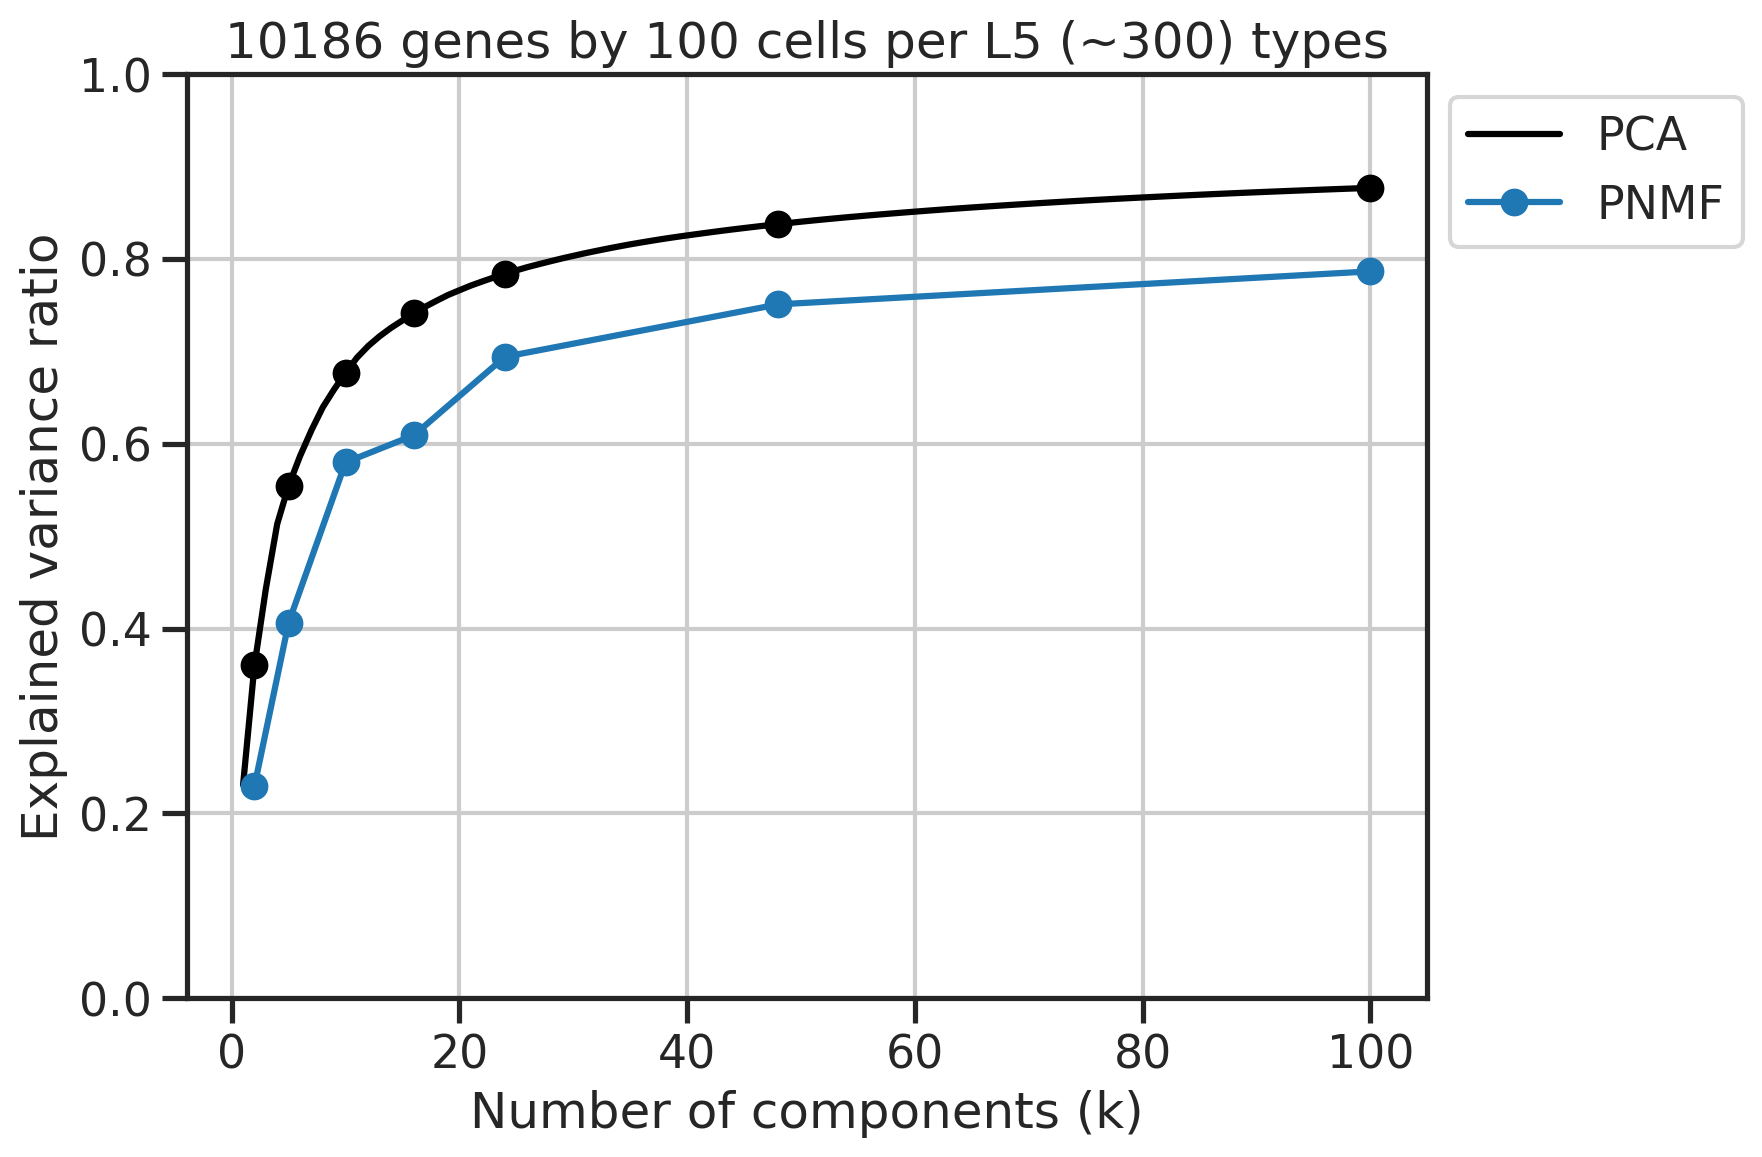

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(1+np.arange(100), cum_var_ratios, '-k', label="PCA")
ax.plot(ks, cum_var_ratios[ks-1], 'ok')
ax.plot(ks, r2s, '-o', label="PNMF")
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance ratio")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"{ngenes} genes by 100 cells per L5 (~300) types")
plt.show()

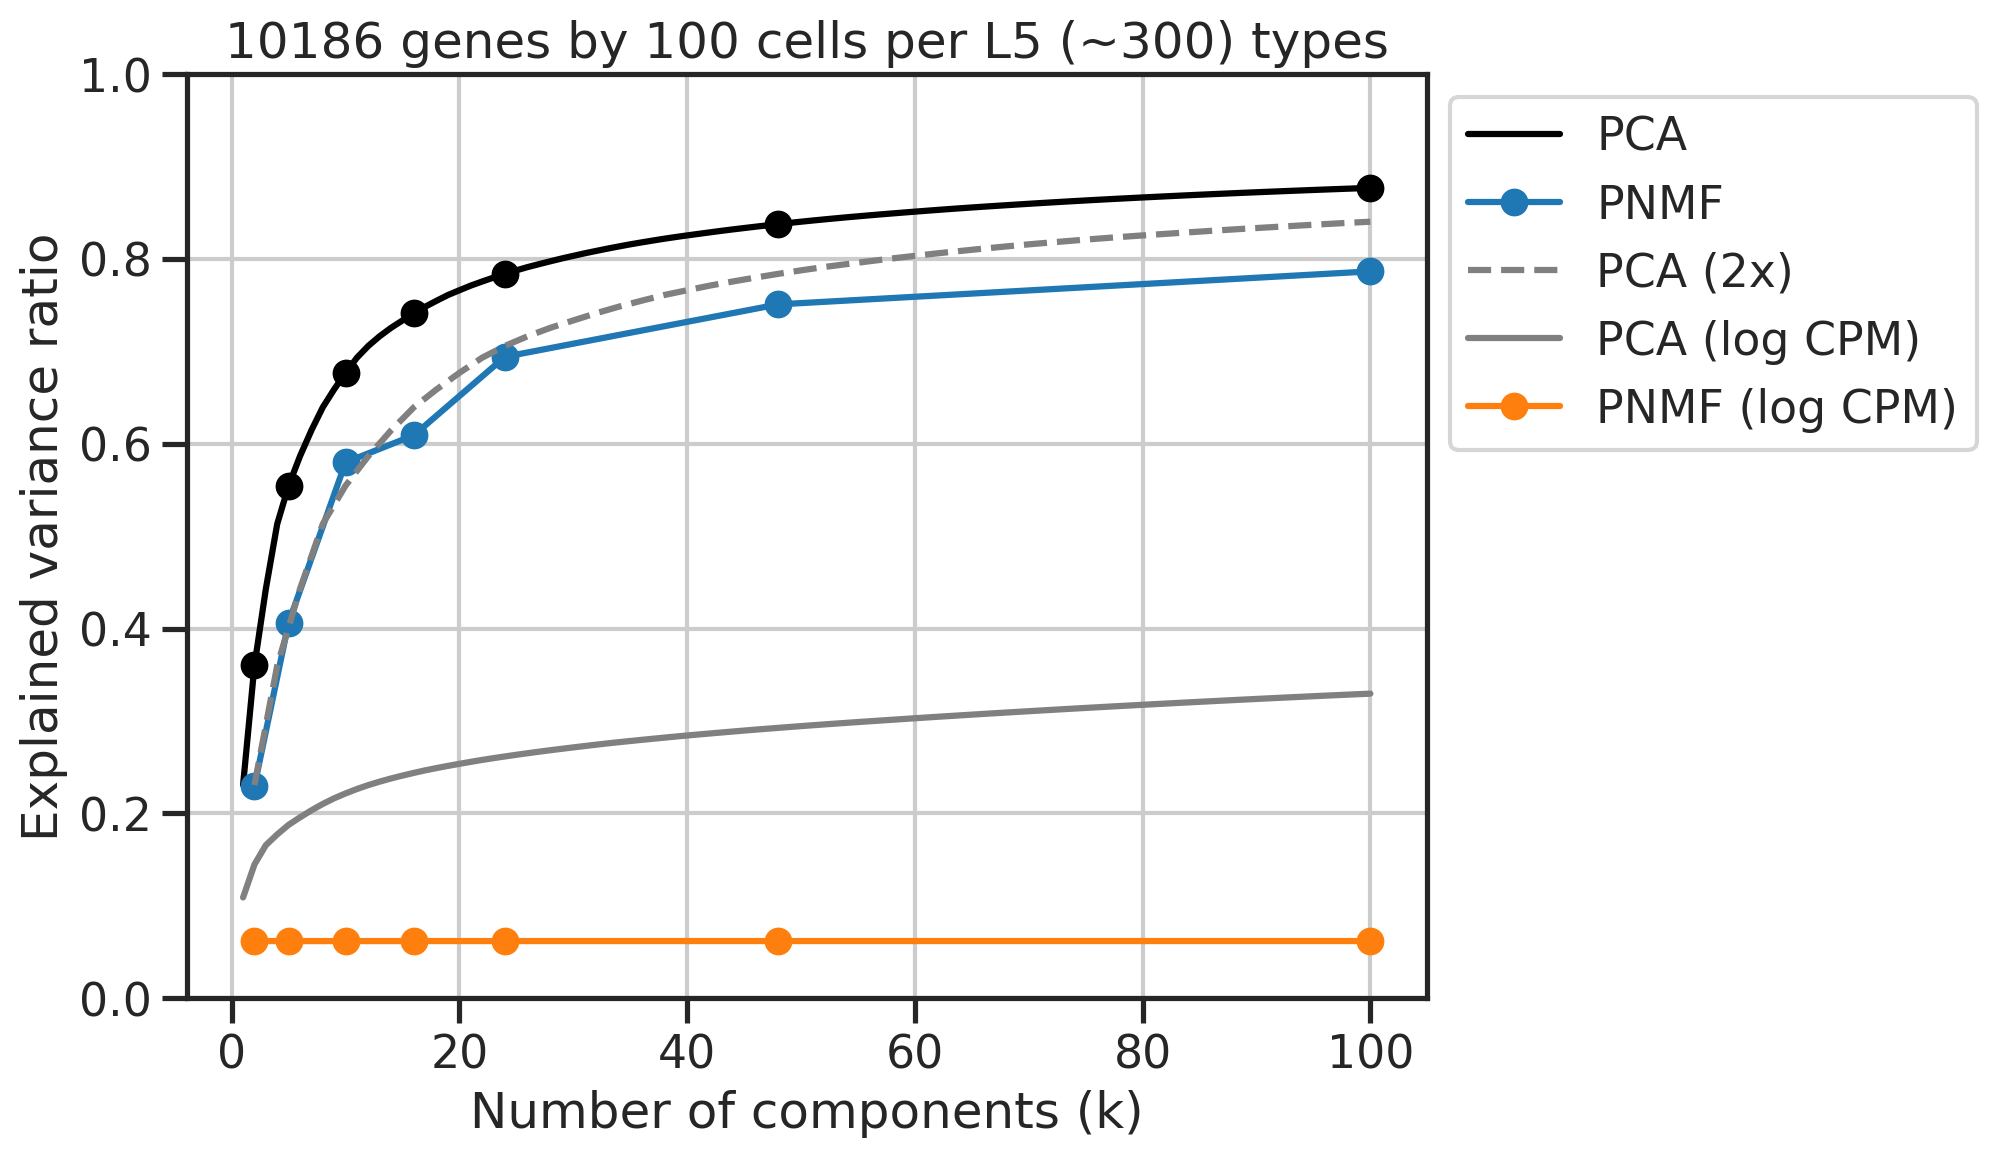

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(1+np.arange(100), cum_var_ratios, '-k', label="PCA")
ax.plot(ks, cum_var_ratios[ks-1], 'ok')
ax.plot(ks, r2s, '-o', label="PNMF")

ax.plot(2*(1+np.arange(100))[:50], cum_var_ratios[:50], '--', label="PCA (2x)", color='gray')
ax.plot(1+np.arange(100), cum_var_ratios_logx, '-', label="PCA (log CPM)", color='gray')
ax.plot(ks, r2s_logx, '-o', label="PNMF (log CPM)")

ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance ratio")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"{ngenes} genes by 100 cells per L5 (~300) types")
plt.show()

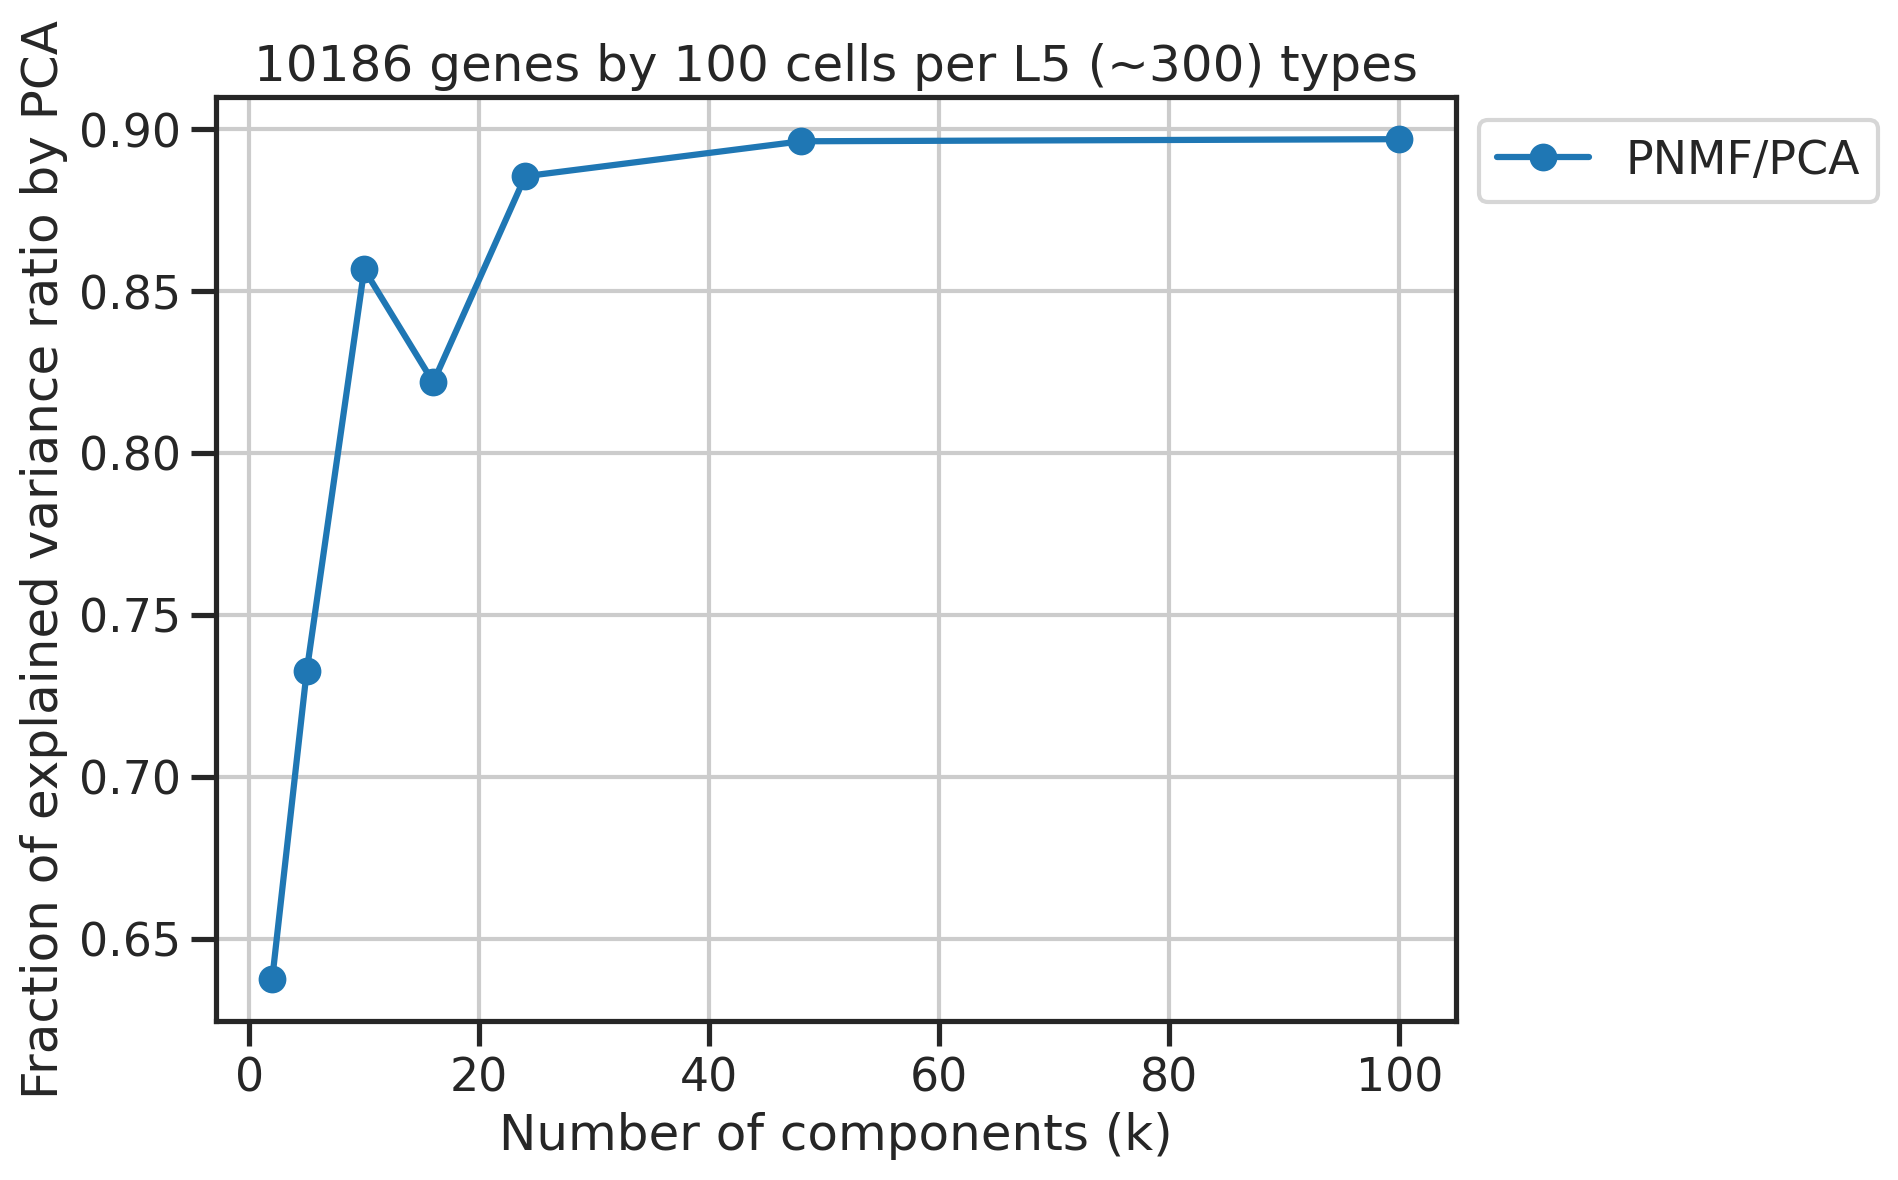

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ks, r2s/cum_var_ratios[ks-1], '-o', label="PNMF/PCA")
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Fraction of explained variance ratio by PCA")
# ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"{ngenes} genes by 100 cells per L5 (~300) types")
plt.show()

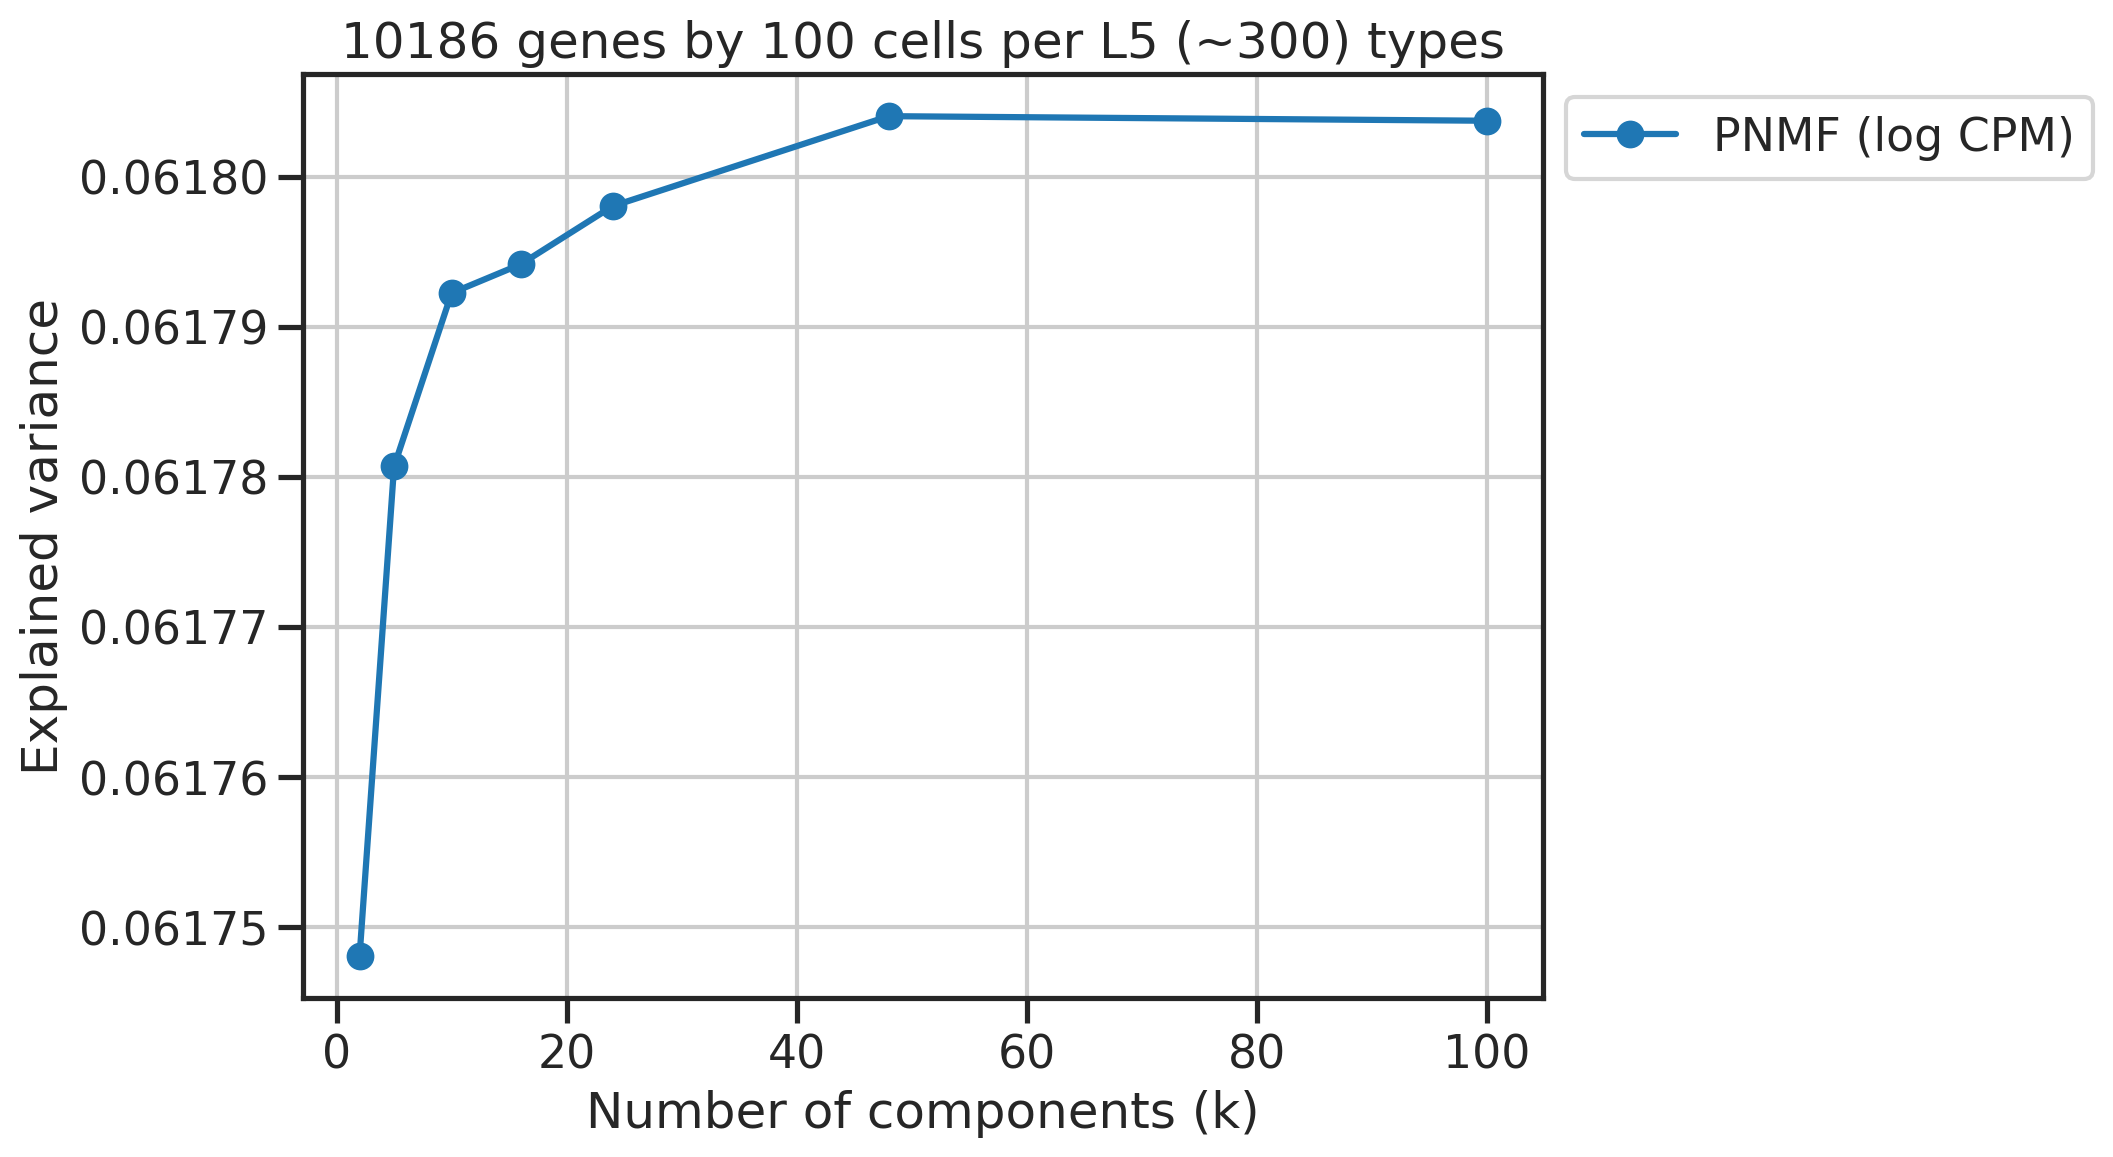

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ks, r2s_logx, '-o', label="PNMF (log CPM)")
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance")
# ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"{ngenes} genes by 100 cells per L5 (~300) types")
plt.show()